In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import os, sys
import astropy.units as u
from fractions import Fraction

# Directory Names

In [16]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import StrainandNoise as SnN
import SNRcalc as SNc

#Save suffix for SNR and Sample data files
save_version = '_1.dat'

# Constants and Initial Parameters

In [10]:
'''
    Variables: 
        'M' - Mass (Solar Units)
        'q' - Mass Ratio
        'chi1' - Spin1
        'chi2' - Spin2
        'z' - Redshift
'''

var_y = 'z' #Variable on y-axis

sampleRate_y = 100 #Number of SNRMatrix rows

var_x = 'M' #Variable on x-axis

sampleRate_x = 100 #Number of SNRMatrix columns

#Selects which noise curve: 0 is Neil Cornish's,
# 							1 is the 2016 proposal,
#							2 is Einstein Telescope, 
#							3 is aLIGO, 
#							4 is NANOGrav 11yr,
#							5 is SKA (2030s),
#							anything else is the L3 proposal
model = 5

#TODO: make general intake of some f,and sqrt(S_n_f)

#M = m1+m2 Total Mass
M = 1e6
M_min = 1e1
M_max = 1e10

#q = m2/m1 reduced mass
q = 1.0
q_min = 1.0
q_max = 18.0

#Chi = S_i*L/m_i**2, spins of each mass i
chi1 = 0.0 #spin of m1
chi2 = 0.0 #spin of m2
chi_min = -0.85 #Limits of PhenomD for unaligned spins
chi_max = 0.85

z = 3.0 #Redshift
z_min = 1e-2
z_max = 1e3

nfreqs = int(1e3)   #Sample rate of strain/Transfer function frequencies

#Make a dictionary of dictionaries to put all values, minima, and maxima in a nice, concise form
var_dict = {'M':{'val':M,'min':M_min,'max':M_max},
            'q':{'val':q,'min':q_min,'max':q_max},
            'chi1':{'val':chi1,'min':chi_min,'max':chi_max},
            'chi2':{'val':chi2,'min':chi_min,'max':chi_max},
            'z':{'val':z,'min':z_min,'max':z_max}}

# Model Selection

In [11]:
if model == 0: #Robson,Cornish,and Liu 2018, LISA (https://arxiv.org/pdf/1803.01944.pdf)
    SNR_save_name = 'LISA_Neil_SNR_Matrix' + save_version
    Sample_save_name = 'LISA_Neil_Samples' + save_version
    save_location = load_directory + 'LISA_Neil/SNRFiles/'
    
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    Neil_L = 2.5e9*u.m #armlength in meters
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=Neil_L)

    Neil_S_acc = 3e-15*u.m/u.s/u.s #M/Hz**2
    Neil_S_oms = 1.5e-11*u.m
    
    S_n_f_sqrt = SnN.NeilSensitivity(f,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
    
elif model == 1: #Martin 2016: LISA Calculation without pathfinder correction (2016 model)
    SNR_save_name = 'LISA_Other_SNR_Matrix' + save_version
    Sample_save_name = 'LISA_Other_Samples' + save_version
    save_location = load_directory + 'LISA_Other/SNRFiles/'
    
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    k2016_L = 2.5e9*u.m #armlength in meters
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=k2016_L)
    
    Ssci = 8.9e-12**2*u.m*u.m
    Sloc = 1.7e-12**2*u.m*u.m
    Sother = 2e-12**2*u.m*u.m
    k2016_P_ims = Ssci+2*Sloc+Sother
    k2016_P_acc = ((1.8e-14*u.m/u.s/u.s)**2*((3e-5*u.Hz/f)**10 + (1e-4*u.Hz/f)**2) + (3e-15*u.m/u.s/u.s)**2)/(2*np.pi*f)**4   #red below 1e-4, white above
    
    S_n_f_sqrt = SnN.calcASD(f,LISA_Transfer_Function,k2016_P_acc,k2016_P_ims,k2016_L)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
    
elif model == 2: #Einstein Telescope
    SNR_save_name = 'ET_SNR_Matrix' + save_version
    Sample_save_name = 'ET_Samples' + save_version
    save_location = load_directory + 'EinsteinTelescope/SNRFiles/'
    load_name = 'ET_D_data.txt'
    load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
    
    ET_data = np.loadtxt(load_location)
    
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    fT = ET_data[:,0]*u.Hz
    S_n_f_sqrt = ET_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
    
elif model == 3: #aLIGO
    SNR_save_name = 'aLIGO_SNR_Matrix' + save_version
    Sample_save_name = 'aLIGO_Samples' + save_version
    save_location = load_directory + 'aLIGO/SNRFiles/'
    load_name = 'aLIGODesign.txt'
    load_location = load_directory + 'aLIGO/StrainFiles/' + load_name
    
    aLIGO_data = np.loadtxt(load_location)
    
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    fT = aLIGO_data[:,0]*u.Hz
    S_n_f_sqrt = aLIGO_data[:,1]
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)
    
elif model == 4: #NANOGrav 11 yr
    SNR_save_name = 'NANOGrav_SNR_Matrix' + save_version
    Sample_save_name = 'NANOGrav_Samples' + save_version
    save_location = load_directory + 'NANOGrav/SNRFiles/'
    
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    T_obs = 11.4*u.yr #Observing time in years
    T_obs = T_obs.to('s') #Observing time in seconds
    
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    ndetectors = 1
    
    fT,S_n_f_sqrt = SnN.calcPTAASD(deltrms_nano,cadence_nano,T_obs,ndetectors,Np_nano)
    
elif model == 5: #SKA (2030s)
    SNR_save_name = 'SKA_SNR_Matrix' + save_version
    Sample_save_name = 'SKA_Samples' + save_version
    save_location = load_directory + 'SKA/SNRFiles/'
    
    ###############################################
    #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
    T_nano = 11.4*u.yr #Observing time in years
    T_nano = T_nano.to('s') #Observing time in seconds
    
    deltrms_nano = 100*u.ns #rms timing residuals in seconds
    deltrms_nano = deltrms_nano.to('s')

    Np_nano = 45 #Number of pulsars
    cadence_nano = 1/(2*u.wk) #Avg observation cadence of 1 every 2 weeks in seconds
    cadence_nano = cadence_nano.to('1/s')
    
    ###############################################
    #SKA calculation using parameters and methods from arXiv:0804.4476 section 7.1
    T_SKA = 15*u.yr #Observing time in years
    T_SKA = T_SKA.to('s') #Observing time in seconds
    
    deltrms_SKA = 10*u.ns #rms timing residuals in nanoseconds
    deltrms_SKA = deltrms_SKA.to('s')

    Np_SKA = 20 #Number of pulsars
    cadence_SKA = 1/u.wk #Avg observation cadence of 1 every week in seconds
    cadence_SKA = cadence_SKA.to('1/s')
    
    ndetectors = 2
    T_obs_full = [T_nano, T_SKA]
    cadence_full = [cadence_nano, cadence_SKA]
    sigma_rms_full = [deltrms_nano, deltrms_SKA]
    N_p_full = [Np_nano, Np_SKA]
    
    T_obs=T_nano+T_SKA

    fT,S_n_f_sqrt = SnN.calcPTAASD(sigma_rms_full,cadence_full,T_obs_full,ndetectors,N_p_full)
    
else: #L3 proposal
    SNR_save_name = 'LISA_ESA_SNR_Matrix' + save_version
    Sample_save_name = 'LISA_ESA_Samples' + save_version
    save_location = load_directory + 'LISA_ESA/SNRFiles/'
    
    T_obs = 4*u.yr.to('s')*u.s #Observing time in seconds
    ESA_L = 2.5e9*u.m #armlength in meters
    fT,LISA_Transfer_Function = SnN.Get_TransferFunction(L=ESA_L)
    
    S_acc_low_knee = .4*u.mHz
    S_acc_high_knee = 8.*u.mHz
    S_oms_knee = 2.*u.mHz
    
    S_n_f_sqrt = SnN.LisaSensitivity(fT,LISA_Transfer_Function)
    S_n_f_sqrt = S_n_f_sqrt/(u.Hz)**Fraction(1,2)

# Setting Up SNR Calculation
Uses the variables given and the data range to sample the space either logrithmically or linearly based on the 
selection of variables. Then it computes the SNR for each value.
Returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the sample1Xsample2


In [12]:
[sample_x,sample_y,SNRMatrix] = SNc.getSNRMatrix(var_dict,fT,S_n_f_sqrt,T_obs,var_x,sampleRate_x,var_y,sampleRate_y)

/Users/andrewkaiser/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


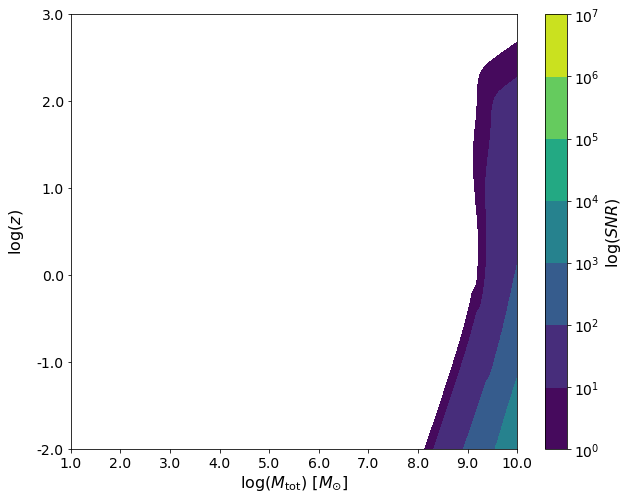

In [31]:
SNc.plotSNR(var_dict,var_x,sample_x,var_y,sample_y,SNRMatrix)

In [14]:
#SNc.saveSNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)